# 基础因子实时计算

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
sys.path.append('../../../../')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from PyFin.api import *
from alphamind.api import *
from conf.models import *
from conf.config import*
from data.engines.model import Record
from alphamind.execution.naiveexecutor import NaiveExecutor
from stacking import factor_store, feature_list
from optimization.bayes_optimization_xgb import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)


## 因子数据准备

In [2]:
# 指定需要执行的日期和保存的文件夹
# start_date = '2010-01-19'  # 训练集的起始时间
start_date = '2019-10-15'  # 训练集的起始时间
end_date = '2019-12-24'
# 设置保存的文件目录
weekly = 's3'  # s1: 周一, s2: 周二,  s3: 周三, s4: 周四, s5: 周五


In [3]:
universe = Universe('zz500')
freq = '5b'
benchmark_code = 905
ref_dates = makeSchedule(start_date, end_date, freq, 'china.sse')
horizon = map_freq(freq)
industry_name = 'sw'
industry_level = 1

# 前一个调仓日, 用于获取前一个调仓日的持仓信息
ref_date_pre = ref_dates[-2]
# 当前调仓日
ref_date = ref_dates[-1]

# 因子数据库
data_source = alpha_db
engine = SqlEngine(data_source)
ref_dates

[datetime.datetime(2019, 10, 15, 0, 0),
 datetime.datetime(2019, 10, 22, 0, 0),
 datetime.datetime(2019, 10, 29, 0, 0),
 datetime.datetime(2019, 11, 5, 0, 0),
 datetime.datetime(2019, 11, 12, 0, 0),
 datetime.datetime(2019, 11, 19, 0, 0),
 datetime.datetime(2019, 11, 26, 0, 0),
 datetime.datetime(2019, 12, 3, 0, 0),
 datetime.datetime(2019, 12, 10, 0, 0),
 datetime.datetime(2019, 12, 17, 0, 0),
 datetime.datetime(2019, 12, 24, 0, 0)]

In [4]:
# uqer因子列表
basic_factor_store = factor_store.basic_factor_store
# alpha191因子列表
alpha_factor_store = factor_store.alpha_factor_store

In [5]:
%%time
# 提取Uqer因子
basic_factor_org = engine.fetch_factor_range(universe, basic_factor_store, dates=ref_dates)
# 提取alpha191因子
# alpha191_factor_org = engine.fetch_factor_range(universe, 
#                                                 alpha_factor_store, 
#                                                 dates=ref_dates, 
#                                                 used_factor_tables=[Alpha191]).drop(['chgPct','secShortName'], axis=1)
# # 合并所有的因子
# factor_data_org = pd.merge(basic_factor_org, alpha191_factor_org, on=['trade_date', 'code'], how='outer')
factor_data_org = basic_factor_org


CPU times: user 10.4 s, sys: 570 ms, total: 11 s
Wall time: 12.1 s


In [6]:
len(set(factor_data_org['trade_date']))

11

In [7]:
assert len(set(factor_data_org['trade_date'])) == len(ref_dates)


Text(0, 0.5, 'ACCA')

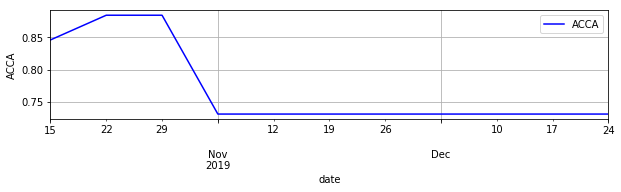

In [8]:
# Plot factor value over time on code
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 2 # width 10, height 8

ax = factor_data_org[factor_data_org['code'] == 6].plot(x='trade_date', y='ACCA', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("ACCA")

In [9]:
# 因子预处理
## 确失值填充
factor_mean = factor_data_org.mean()
factor_std = factor_data_org.std()
factor_data_org = factor_data_org.fillna(factor_mean)

In [10]:
%%time
# 获取所属行业
industry = engine.fetch_industry_range(universe, dates=ref_dates)
# factor_data = pd.merge(factor_data_org, industry, on=['trade_date', 'code']).fillna(0.)
factor_data = pd.merge(factor_data_org, industry, on=['trade_date', 'code'])

# 获取风险因子
risk_total = engine.fetch_risk_model_range(universe, dates=ref_dates)[1]


CPU times: user 155 ms, sys: 22.1 ms, total: 177 ms
Wall time: 296 ms


In [27]:
%%time
return_data = engine.fetch_dx_return_range(universe, dates=ref_dates, horizon=horizon, offset=0,benchmark = benchmark_code)


CPU times: user 64.8 ms, sys: 4.11 ms, total: 68.9 ms
Wall time: 312 ms


In [28]:
return_data.head()

,trade_date,code,dx
0,2019-10-15,6,-0.010240
10,2019-10-15,8,0.010982
20,2019-10-15,9,-0.014547
30,2019-10-15,12,0.030810
40,2019-10-15,21,-0.023236


In [12]:
%%time
benchmark_total = engine.fetch_benchmark_range(dates=ref_dates, benchmark=benchmark_code)
industry_total = engine.fetch_industry_matrix_range(universe, dates=ref_dates, category=industry_name, level=industry_level)

train_data = pd.merge(factor_data, return_data, on=['trade_date', 'code']).dropna()


CPU times: user 96.2 ms, sys: 13.1 ms, total: 109 ms
Wall time: 151 ms


Text(0, 0.5, 'dx')

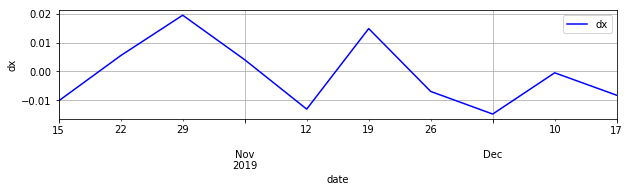

In [13]:
# Plot adjusted close over time on code
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 2 # width 10, height 8

ax = train_data[train_data['code'] == 6].plot(x='trade_date', y='dx', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("dx")

In [14]:
# 获取特征名
features = list(basic_factor_store.keys())
alpha_features = list(alpha_factor_store.keys())
# features = feature_list.uqer_features
# alpha_features = feature_list.alpha_features
# features.extend(alpha_features)

label = ['dx']

## 模型训练

In [15]:
from datetime import datetime, timedelta
from models.m1_xgb import *
from conf.configuration import xgb_conf
from data.engines.model import Record
import xgboost as xgb
import gc

alpha_logger.info('{0} is start'.format(ref_date))

# machine learning model
## Filter Training data
## 训练集构造
trade_date_pre = ref_date - timedelta(days=1)
# trade_date_pre_80 = ref_date - timedelta(days=80)

## 1、选择调仓日当天之前(不含当天)并且在80天以内的因子数据作为训练集.
# train = train_data[(train_data.trade_date <= trade_date_pre) & (trade_date_pre_80 <= train_data.trade_date)].dropna()
## 2、选择调仓日当天之前(不含当天)的因子数据作为训练集.
train = train_data[train_data.trade_date <= trade_date_pre].dropna()
alpha_logger.info('trade_date_pre {0}'.format(trade_date_pre))

if len(train) <= 0:
    alpha_logger.info('{0} HAS NO TRAIN DATA!!!'.format(ref_date))

x_train = train[features]
y_train = train[label]
alpha_logger.info('len_x_train: {0}, len_y_train: {1}'.format(len(x_train.values), len(y_train.values)))
alpha_logger.info('X_train.shape={0}, X_test.shape = {1}'.format(np.shape(x_train), np.shape(y_train)))


2019-12-25 05:45:06,938 - ALPHA_MIND - INFO - 2019-12-24 00:00:00 is start
2019-12-25 05:45:06,975 - ALPHA_MIND - INFO - trade_date_pre 2019-12-23 00:00:00
2019-12-25 05:45:06,983 - ALPHA_MIND - INFO - len_x_train: 5000, len_y_train: 5000
2019-12-25 05:45:06,984 - ALPHA_MIND - INFO - X_train.shape=(5000, 423), X_test.shape = (5000, 1)


## 超参寻优

In [16]:
# load xgboost regression configuration
xgb_conf.xgb_config_r()
xgb_conf.cv_folds = None
xgb_conf.early_stop_round = 100
xgb_conf.max_round = 800
xgb_conf.params.update({'nthread': 12})

GPU_device = False
if GPU_device:
    # use GPUs
    xgb_conf.params.update({'tree_method': 'gpu_hist'})
alpha_logger.info("params before: {}".format(xgb_conf.params))
tic = time.time()

# hyper_parameters optimization
# opt_parameters = {'max_depth': (2, 12),
#                   'gamma': (0.001, 10.0),
#                   'min_child_weight': (0, 20),
#                   'max_delta_step': (0, 10),
#                   'subsample': (0.01, 0.99),
#                   'colsample_bytree': (0.01, 0.99)
#                  }

# opt_xgb = BayesOptimizationXGB('regression', x_train, y_train)
# params_op = opt_xgb.train_opt(opt_parameters)
# xgb_conf.params.update(params_op)
alpha_logger.info("params after: {}".format(xgb_conf.params))
alpha_logger.info("hyper params optimize time : {}".format(time.time() - tic))


2019-12-25 05:45:06,991 - ALPHA_MIND - INFO - params before: {'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 12, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2019-12-25 05:45:06,992 - ALPHA_MIND - INFO - params after: {'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 12, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2019-12-25 05:45:06,992 - ALPHA_MIND - INFO - hyper params optimize time : 0.0007941722869873047


## 模型训练

In [17]:
# model training
xgb_model = XGBooster(xgb_conf)
alpha_logger.info('xgb_model params: \n{0}'.format(xgb_model.get_params()))

best_score, best_round, best_model = xgb_model.fit(x_train, y_train)
alpha_logger.info('Training time cost {}s'.format(time.time() - tic))
alpha_logger.info('best_score = {}, best_round = {}'.format(best_score, best_round))


2019-12-25 05:45:06,997 - ALPHA_MIND - INFO - xgb_model params: 
{'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 12, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2019-12-25 05:45:06,998 - ../../../../models/m1_xgb.py[line:95] - INFO: NonCrossValidation。。。。


[0]	train-rmse:0.498209	train-logloss:0.683143
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473948	train-logloss:0.635908
[10]	train-rmse:0.450879	train-logloss:0.592944
[15]	train-rmse:0.428935	train-logloss:0.553691
[20]	train-rmse:0.408086	train-logloss:0.517746
[25]	train-rmse:0.388267	train-logloss:0.484706
[30]	train-rmse:0.369424	train-logloss:0.454248
[35]	train-rmse:0.351515	train-logloss:0.42611
[40]	train-rmse:0.334483	train-logloss:0.400037
[45]	train-rmse:0.318305	train-logloss:0.37586
[50]	train-rmse:0.302918	train-logloss:0.353368
[55]	train-rmse:0.288312	train-logloss:0.332451
[60]	train-rmse:0.274412	train-logloss:0.312913
[65]	train-rmse:0.261203	train-logloss:0.294668
[70]	train-rmse:0.248645	train-logloss:0.277597
[75]	train-rmse:0.236736	train-logloss:0.261645
[80]	train-rmse:0.225414	train-logloss:0.246683
[85]	train-rmse:0.214679	train-loglo

2019-12-25 05:45:11,088 - ALPHA_MIND - INFO - Training time cost 4.096323490142822s
2019-12-25 05:45:11,089 - ALPHA_MIND - INFO - best_score = {'best_score': -0.397576}, best_round = 799


## 当天数据预测

In [18]:
# 取调仓日当天的因子数据作为输入.
# total_data_test_excess = train_data[train_data.trade_date == str(ref_date)]
total_data_test_excess = factor_data[factor_data.trade_date == ref_date]

if len(total_data_test_excess) <=0:
    alpha_logger.info('{} HAS NO DATA!!!'.format(ref_date))
    sys.exit()

alpha_logger.info('{0} total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))

# 获取调仓日当天的行业, 风险模型和基准权重数据
industry_matrix = industry_total[industry_total.trade_date == ref_date]
benchmark_weight = benchmark_total[benchmark_total.trade_date == ref_date]
risk_matrix = risk_total[risk_total.trade_date == ref_date]

total_data = pd.merge(industry_matrix, benchmark_weight, on=['code'], how='left').fillna(0.)
total_data = pd.merge(total_data, risk_matrix, on=['code'])
alpha_logger.info('{0} type_of_total_data: {1}'.format(ref_date, type(total_data)))
alpha_logger.info('{0} shape_of_total_data: {1}'.format(ref_date, np.shape(total_data)))
    
total_data_test_excess = pd.merge(total_data, total_data_test_excess, on=['code'])
alpha_logger.info('{0} len_of_total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))

# 股票代码
codes = total_data_test_excess.code.values.tolist()
   
# predict
# alpha_logger.info('total_data_test_excess: \n{}'.format(total_data_test_excess[['weight', 'code', 'industry']]))
x_pred = total_data_test_excess[features]
predict_xgboost = xgb_model.predict(best_model, x_pred)
# alpha_logger.info('predict_xgboost: {}'.format(predict_xgboost))

a = np.shape(predict_xgboost)
predict_xgboost = np.reshape(predict_xgboost, (a[0], -1)).astype(np.float64)
alpha_logger.info('shape_of_predict_xgboost: {}'.format(np.shape(predict_xgboost)))

# 收益率预测结果    
predict_xgboost_df = pd.DataFrame({'xgb_pre': list(predict_xgboost.reshape(-1))})
predict_xgboost_df['trade_date'] = ref_date
predict_xgboost_df['code'] = codes
predict_xgboost_df['code'] = predict_xgboost_df['code'].apply(lambda x: "{:06d}".format(x) + '.XSHG'
                                                              if len(str(x))==6 and str(x)[0] in '6' 
                                                              else "{:06d}".format(x) + '.XSHE')


2019-12-25 05:45:11,125 - ALPHA_MIND - INFO - 2019-12-24 00:00:00 total_data_test_excess: 500
2019-12-25 05:45:11,138 - ALPHA_MIND - INFO - 2019-12-24 00:00:00 type_of_total_data: <class 'pandas.core.frame.DataFrame'>
2019-12-25 05:45:11,138 - ALPHA_MIND - INFO - 2019-12-24 00:00:00 shape_of_total_data: (500, 74)
2019-12-25 05:45:11,145 - ALPHA_MIND - INFO - 2019-12-24 00:00:00 len_of_total_data_test_excess: 500
2019-12-25 05:45:11,158 - ALPHA_MIND - INFO - shape_of_predict_xgboost: (500, 1)


## 获取昨持仓信息

In [19]:
from data.engines.sqlengine import SQLEngine

# 获取当前持仓
record_engine = SQLEngine('sqlite:///./{}/real_tune_record_without_alpha.db'.format(weekly))

try:
    pos_record = record_engine.fetch_record('pos_record')
    previous_pos = pos_record[pos_record['trade_date'] == ref_date_pre]
except Exception as e:
    alpha_logger.info('pos_record Exception:{0}'.format(e))
    previous_pos = pd.DataFrame({'trade_date':[], 'weight':[],'industry':[], 'er':[],'code':[]})

alpha_logger.info('previous_pos_data: {0}, pos_len: {1}'.format(ref_date_pre, len(previous_pos)))

# 股票过滤, 组合优化之前过滤掉(未完成)
## 9:00--9:25之间进行涨跌停股票的实时筛选

# 导入昨持仓并与股票池中所有股票合并, 
if len(previous_pos) <= 0:
    current_position = None
else:
    previous_pos = total_data_test_excess[['code']].merge(previous_pos, on=['code'], how='left',).fillna(0)
    current_position = previous_pos.weight.values
alpha_logger.info('previous_pos:\n {}'.format(previous_pos))

# previous_pos = total_data_test_excess[['code']].merge(previous_pos, on=['code'], how='left').fillna(0)
# current_position = previous_pos.weight.values

# print(current_position.shape)
# print(total_data_test_excess.shape)
# print(previous_pos.shape)
current_position

2019-12-25 05:45:11,209 - ALPHA_MIND - INFO - previous_pos_data: 2019-12-17 00:00:00, pos_len: 500
2019-12-25 05:45:11,233 - ALPHA_MIND - INFO - previous_pos:
        code        weight industry        er trade_date
0         6  6.553185e-10      房地产  0.000096 2019-12-17
1         8  0.000000e+00     机械设备 -0.001430 2019-12-17
2         9  3.719212e-10       综合 -0.010312 2019-12-17
3        12  0.000000e+00     建筑材料 -0.011075 2019-12-17
4        21  1.859513e-10       电子 -0.004677 2019-12-17
5        25  3.947961e-10       汽车 -0.007531 2019-12-17
6        27  5.269509e-10     公用事业 -0.006994 2019-12-17
7        28  6.352115e-10     医药生物 -0.002236 2019-12-17
8        31  4.539283e-10      房地产 -0.004747 2019-12-17
9        39  2.459365e-10     机械设备 -0.006178 2019-12-17
10       60  1.098004e-02     有色金属  0.007697 2019-12-17
11       61  3.185963e-10     商业贸易 -0.004313 2019-12-17
12       62  0.000000e+00       电子 -0.002444 2019-12-17
13       66  1.287271e-09      计算机  0.001247 2019-12-17


array([6.55318531e-10, 0.00000000e+00, 3.71921210e-10, 0.00000000e+00,
       1.85951289e-10, 3.94796082e-10, 5.26950865e-10, 6.35211474e-10,
       4.53928274e-10, 2.45936463e-10, 1.09800427e-02, 3.18596322e-10,
       0.00000000e+00, 1.28727091e-09, 5.23972361e-10, 0.00000000e+00,
       4.33511361e-10, 2.51843022e-10, 1.02901445e-09, 6.45789511e-10,
       2.70999695e-10, 4.76084429e-10, 7.25108823e-10, 5.12805276e-10,
       4.05452629e-10, 6.88982752e-03, 2.58723348e-09, 0.00000000e+00,
       1.48521708e-10, 6.58596434e-10, 2.98909955e-10, 4.27126468e-10,
       1.67693237e-09, 1.88401265e-02, 4.61644385e-10, 2.87740184e-10,
       1.69614720e-10, 2.28799945e-02, 9.84078703e-10, 6.19512598e-10,
       0.00000000e+00, 0.00000000e+00, 2.02761033e-10, 0.00000000e+00,
       5.21286434e-10, 5.80417340e-10, 5.01593369e-10, 1.36697195e-09,
       2.14299574e-02, 5.78181790e-10, 6.10527493e-10, 2.27871066e-10,
       4.19384593e-10, 4.27039908e-10, 1.82899805e-02, 4.29810682e-10,
      

## 组合优化

In [20]:
# Constraintes settings
industry_names = industry_list(industry_name, industry_level)
constraint_risk = ['EARNYILD', 'LIQUIDTY', 'GROWTH', 'SIZE', 'SIZENL', 'BETA', 'MOMENTUM'] + industry_names

total_risk_names = constraint_risk + ['benchmark', 'total']

b_type = []
l_val = []
u_val = []

for name in total_risk_names:
    if name == 'benchmark':
        b_type.append(BoundaryType.RELATIVE)
        l_val.append(0.0)
        u_val.append(1.0)
    elif name == 'total':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.0)
        u_val.append(0.0)
    elif name == 'SIZE':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-1.0)
        u_val.append(1.0)
    elif name == 'SIZENL':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-1.0)
        u_val.append(1.0)
    elif name in industry_names:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.005)
        u_val.append(0.005)
    else:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-2.0)
        u_val.append(2.0)
bounds = create_box_bounds(total_risk_names, b_type, l_val, u_val)


In [21]:
benchmark_w = total_data_test_excess.weight.values
alpha_logger.info('type_of_benchmark_w: {}, shape_of_benchmark_w: {}'.format(type(benchmark_w), 
                                                                             np.shape(benchmark_w)))
is_in_benchmark = (benchmark_w > 0.).astype(float).reshape((-1, 1))

# 风险模型数据合并
weight_gap = 0.02
total_risk_exp = np.concatenate([total_data_test_excess[constraint_risk].values.astype(float),
                                 is_in_benchmark,
                                 np.ones_like(is_in_benchmark)],
                                axis=1)

alpha_logger.info('shape_of_total_risk_exp_pre: {}'.format(np.shape(total_risk_exp)))
total_risk_exp = pd.DataFrame(total_risk_exp, columns=total_risk_names)
alpha_logger.info('shape_of_total_risk_exp: {}'.format(np.shape(total_risk_exp)))

constraints = LinearConstraints(bounds, total_risk_exp, benchmark_w)
alpha_logger.info('constraints: {0} in {1}'.format(np.shape(constraints.risk_targets()), ref_date))

lbound = np.maximum(0., benchmark_w - weight_gap)
ubound = weight_gap + benchmark_w
alpha_logger.info('lbound: {0} in {1}'.format(np.shape(lbound), ref_date))
alpha_logger.info('ubound: {0} in {1}'.format(np.shape(ubound), ref_date))

# 组合优化
executor = NaiveExecutor()
current_pos = pd.DataFrame()

target_pos, _ = er_portfolio_analysis(predict_xgboost, 
                                      total_data_test_excess['industry'].values,
                                      None,
                                      constraints,
                                      False,
                                      benchmark_w,
                                      method='risk_neutral',
                                      lbound=lbound,
                                      ubound=ubound,
                                      turn_over_target=0.5,
                                      current_position=current_position)
                  
alpha_logger.info('shape_of_target_pos: {}'.format(np.shape(target_pos)))
alpha_logger.info('len_codes:{}'.format(np.shape(codes)))
target_pos['code'] = codes
# alpha_logger.info('target_pos: \n{}'.format(target_pos))

# 换手率计算
executor.set_current(previous_pos)
turn_over_org, current_pos = executor.execute(target_pos=target_pos)
alpha_logger.info('turn_over_org: {}'.format(turn_over_org))
turn_over = turn_over_org / sum(target_pos.weight.values)
alpha_logger.info('turn_over: {}'.format(turn_over))

# 优化后仓位信息
current_pos['trade_date'] = ref_date
alpha_logger.info('{} is finished'.format(ref_date))


2019-12-25 05:45:11,257 - ALPHA_MIND - INFO - type_of_benchmark_w: <class 'numpy.ndarray'>, shape_of_benchmark_w: (500,)
2019-12-25 05:45:11,259 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2019-12-25 05:45:11,260 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2019-12-25 05:45:11,262 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-12-24 00:00:00
2019-12-25 05:45:11,262 - ALPHA_MIND - INFO - lbound: (500,) in 2019-12-24 00:00:00
2019-12-25 05:45:11,263 - ALPHA_MIND - INFO - ubound: (500,) in 2019-12-24 00:00:00
2019-12-25 05:45:11,321 - ALPHA_MIND - INFO - shape_of_target_pos: (500, 3)
2019-12-25 05:45:11,322 - ALPHA_MIND - INFO - len_codes:(500,)
2019-12-25 05:45:11,332 - ALPHA_MIND - INFO - turn_over_org: 0.5000000000007779
2019-12-25 05:45:11,333 - ALPHA_MIND - INFO - turn_over: 0.5000350024509492
2019-12-25 05:45:11,334 - ALPHA_MIND - INFO - 2019-12-24 00:00:00 is finished


In [22]:
# 修改code格式
# 取TOP N作为真实的下单股票
real_pos = current_pos.sort_values(by='weight', ascending=False)[:50]
real_pos['weight'] = real_pos['weight'] / real_pos['weight'].sum()
real_pos

,weight,industry,er,code,trade_date
66,0.027804,食品饮料,0.003311,860,2019-12-24
481,0.026614,电子,0.024361,603501,2019-12-24
252,0.026169,机械设备,0.016271,300450,2019-12-24
208,0.025372,医药生物,0.011652,2821,2019-12-24
301,0.024792,农林牧渔,0.008007,600298,2019-12-24
211,0.024771,电子,0.014898,2916,2019-12-24
390,0.024771,建筑材料,0.012184,600801,2019-12-24
146,0.024616,电子,0.025216,2371,2019-12-24
366,0.024347,医药生物,0.001858,600673,2019-12-24
411,0.024254,电气设备,0.022430,600885,2019-12-24


In [23]:
# 保存记录当前持仓信息, 写入数据库
# previous_record = record_engine.fetch_record_meta(Record, ref_date)
# if len(previous_record) == 0:
#     record_engine.write_data('pos_record', real_pos)
# else:
#     record_engine.del_historical_data(Record, ref_date)  # 删除同日期的历史数据
#     tmp_record = record_engine.fetch_record_meta(Record, ref_date)
#     if len(tmp_record) == 0:  # 删除成功
#         record_engine.write_data('pos_record', real_pos)
#     else:
#         print('{} 的数据没有删除: {}'.format(ref_date, len(previous_record)))


In [24]:
# 生成交易记录
## 修改code格式
real_pos['code'] = real_pos['code'].apply(lambda x: "{:06d}".format(x) + '.SH' 
                                          if len(str(x))==6 and str(x)[0] in '6' 
                                          else "{:06d}".format(x) + '.SZ')

real_pos = real_pos.loc[:, ['code', 'weight', 'trade_date']]
real_pos.rename(columns={"code": "证券代码", "weight": "持仓权重", "trade_date": "成分日期"}, inplace=True)
real_pos['交易价格'] = 0

real_pos = real_pos[['证券代码', '持仓权重', '交易价格', '成分日期']].copy()
# real_pos.to_csv('./{}/base{}.csv'.format(weekly, end_date), encoding='utf_8_sig', index=False)

In [25]:
previous_record = record_engine.fetch_record_meta(Record, ref_date)
# previous_record = previous_record[previous_record['trade_date'] == ref_date]
previous_record

,trade_date,weight,industry,er,code
0,2019-12-24 00:00:00.000000,0.027804,食品饮料,0.003311,860
1,2019-12-24 00:00:00.000000,0.026614,电子,0.024361,603501
2,2019-12-24 00:00:00.000000,0.026169,机械设备,0.016271,300450
3,2019-12-24 00:00:00.000000,0.025372,医药生物,0.011652,2821
4,2019-12-24 00:00:00.000000,0.024792,农林牧渔,0.008007,600298
5,2019-12-24 00:00:00.000000,0.024771,电子,0.014898,2916
6,2019-12-24 00:00:00.000000,0.024771,建筑材料,0.012184,600801
7,2019-12-24 00:00:00.000000,0.024616,电子,0.025216,2371
8,2019-12-24 00:00:00.000000,0.024347,医药生物,0.001858,600673
9,2019-12-24 00:00:00.000000,0.024254,电气设备,0.022430,600885


In [26]:
previous_record['trade_date'][0]

'2019-12-24 00:00:00.000000'